# Data Model for Object Detection
The task here is to prepare a TFRecord dataset that can be fed into the [object detection API of tensorflow](https://github.com/tensorflow/models/tree/master/research/object_detection). This notebook uses a subset of the [GSSS](https://datadryad.org/resource/doi:10.5061/dryad.5pt92) dataset that were used in this [paper](https://datadryad.org/resource/doi:10.5061/dryad.5pt92) by Schneider! <br> 
I broke down the data model into the following steps:<br>
1. Database creation - As part of this step I work on consolidating the input data in various format into a one json file.
2. Using this json to create a tensorflow record
3. Validating the pipeline


The detailed steps that I follow are:
1. Data Export : CSV (from the panoptes API) -> JSON file
2. Data Import : JSON file -> Dictionary object 
3. Write TFRecord : Dictionary Object -> TFRecord file
4. Validate data in the TFRecord

## Importing necessary packages

In [1]:
#import pandas as pd
import csv, os, sys
import operator
import tensorflow as tf
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
sys.path.append('/home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/data/')
from utils import dataset_util
#Added this to handle the truncation error while decoding the jpeg
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
Project_filepath = "/home/ubuntu/data/tensorflow/my_workspace/training_demo/"#"/home/rai00007/Desktop/zooniverse/" # Original data - "/data/lucifer1.2/users/rai00007/"

In [4]:
df_schneider_box = pd.read_csv(Project_filepath + 'Data/GoldStandardBoundBoxCoord.csv')
schneider_events = list(set(df_schneider_box['filename']))
schneider_events = [word.split('.')[0] for word in schneider_events] # [word[:-4] for word in schneider_events]
print(len(schneider_events))
print(set(df_schneider_box['class']))
df_schneider_box.head()

4011
{'Impala', 'Topi', 'WattledStarling', 'CattleEgret', 'Aardvark', 'Ostrich', 'Warthog', 'Porcupine', 'GazelleThomsons', 'SuperbStarling', 'DikDik', 'Hare', 'Buffalo', 'Jackal', 'BuffCrestedBustard', 'Stork', 'Aardwolf', 'KoriBustard', 'Leopard', 'Rodent', 'Cheetah', 'Reedbuck', 'SecretaryBird', 'Giraffe', 'GuineaFowl', 'GreyBackedFiscal', 'Waterbuck', 'WhiteHeadBuffaloWeaver', 'GazelleGrants', 'Hippopotamus', 'Bushbuck', 'Rhinoceros', 'Zebra', 'HyenaSpotted', 'Lion', 'Mongoose', 'Wildebeest', 'Oxpecker', 'Serval', 'Baboon', 'OtherBird', 'Elephant', 'Human', 'Hartebeest', 'VervetMonkey', 'Eland'}


,filename,width,height,class,xmin,ymin,xmax,ymax
0,ASG000dz24.jpg,2048,1536,Impala,1141,883,1227,977
1,ASG000dz24.jpg,2048,1536,Impala,1340,876,1381,925
2,ASG000dz24.jpg,2048,1536,Impala,1448,803,1538,1042
3,ASG000dz24.jpg,2048,1536,Impala,1382,763,1485,1080
4,ASG000c7hr.jpg,2048,1536,Wildebeest,1987,680,2048,751


**Preprocessing:**
1. Cleaning the values of class to match with lila label map
    - Manual check was done to get to the list of values that need to be changes
2. Write it back to the disk

In [4]:
lst_remove_species = ['buffCrestedBustard','cattleEgret','greyBackedFiscal',\
                      'oxpecker','stork','superbStarling','wattledStarling', \
                 'whiteHeadBuffaloWeaver', 'lion']
df_schneider_box['class'] = pd.Series([name1[0].lower()+name1[1:]  for name1 in list(df_schneider_box['class'])])
df_schneider_box = df_schneider_box.loc[~df_schneider_box['class'].isin(lst_remove_species)]

df_schneider_box['class'] = df_schneider_box['class'].replace({'rodent': 'rodents'})
df_schneider_box.to_csv(os.path.join(Project_filepath + 'Data/GoldStandardBoundBoxCoord_temp.csv'), sep=',', index=False)
print(set(df_schneider_box['class']))
df_schneider_box.tail()

{'aardvark', 'koriBustard', 'zebra', 'giraffe', 'ostrich', 'gazelleGrants', 'serval', 'rodents', 'rhinoceros', 'dikDik', 'hare', 'bushbuck', 'elephant', 'cheetah', 'warthog', 'jackal', 'hartebeest', 'gazelleThomsons', 'impala', 'aardwolf', 'mongoose', 'reedbuck', 'human', 'hippopotamus', 'buffalo', 'wildebeest', 'topi', 'leopard', 'otherBird', 'guineaFowl', 'vervetMonkey', 'secretaryBird', 'eland', 'porcupine', 'waterbuck', 'hyenaSpotted', 'baboon'}


,filename,width,height,class,xmin,ymin,xmax,ymax
19323,ASG000bzss.jpg,2048,1536,gazelleThomsons,1,196,1985,1536
19324,ASG000czm7.jpg,2048,1536,hartebeest,1739,690,2048,888
19325,ASG000dfal.jpg,2048,1536,zebra,1919,765,2048,1029
19326,ASG000dfal.jpg,2048,1536,zebra,1112,732,1494,999
19327,ASG000dfal.jpg,2048,1536,zebra,667,737,1014,942


In [5]:
lst_keep = ['ASG000c89u.jpg', 'ASG000c005.jpg']
df_schneider_box = df_schneider_box.loc[df_schneider_box['filename'].isin(lst_keep)]
df_schneider_box.to_csv(os.path.join(Project_filepath + 'Data/GoldStandardBoundBoxCoord_sample.csv'), sep=',', index=False)
df_schneider_box

,filename,width,height,class,xmin,ymin,xmax,ymax
1518,ASG000c89u.jpg,2048,1536,Wildebeest,1340,681,1882,1038
1519,ASG000c89u.jpg,2048,1536,Wildebeest,529,641,1055,1019
1520,ASG000c89u.jpg,2048,1536,Wildebeest,1,643,369,1011
2168,ASG000c005.jpg,2048,1536,GazelleThomsons,106,1044,656,1536
2169,ASG000c005.jpg,2048,1536,GazelleThomsons,1738,725,1958,1238
2170,ASG000c005.jpg,2048,1536,GazelleThomsons,1046,727,1205,915


In [26]:
df_all_images = pd.read_csv(Project_filepath + 'Data/all_images.csv')
df_all_images = df_all_images[df_all_images['CaptureEventID'].isin(schneider_events)]
print(df_all_images.shape)
df_all_images.head()

(10597, 2)


,CaptureEventID,URL_Info
1377257,ASG000c6uw,S4/B03/B03_R1/S4_B03_R1_IMAG0137.JPG
1377258,ASG000c6uw,S4/B03/B03_R1/S4_B03_R1_IMAG0138.JPG
1377259,ASG000c6uw,S4/B03/B03_R1/S4_B03_R1_IMAG0139.JPG
1381262,ASG000c6x1,S4/B03/B03_R1/S4_B03_R1_IMAG4142.JPG
1381263,ASG000c6x1,S4/B03/B03_R1/S4_B03_R1_IMAG4143.JPG


In [27]:
df = df_all_images.drop_duplicates(subset='CaptureEventID', keep='first')
df['URL_info_full'] = 'https://snapshotserengeti.s3.msi.umn.edu/' + df['URL_Info'].astype(str)
df.iloc[1]

/home/ubuntu/test_env/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


CaptureEventID                                           ASG000c6x1
URL_Info                       S4/B03/B03_R1/S4_B03_R1_IMAG4142.JPG
URL_info_full     https://snapshotserengeti.s3.msi.umn.edu/S4/B0...
Name: 1381262, dtype: object

**Download the images**

In [7]:
import os, sys, random, ssl
import urllib, urllib.request

In [8]:
def get_images_from_url(dataset, image_name_index, url_col_index, outpath):
    if (not os.environ.get('PYTHONHTTPSVERIFY', '') and
        getattr(ssl, '_create_unverified_context', None)): 
        ssl._create_default_https_context = ssl._create_unverified_context
        
        check = []
        
        for i in range(dataset.shape[0]):
            if dataset.iloc[i][image_name_index] not in check:
                j = 0
            if dataset.iloc[i][image_name_index] in check:
                j += 1 
            
            print('Processing image: %d' % i)
            
            urllib.request.urlretrieve(dataset.iloc[i][url_col_index], outpath+'{0}.jpg'\
                                       .format(dataset.iloc[i][image_name_index] ))

In [9]:
outpath = '../data/LILA/schneider_images/'
# get_images_from_url(df, 0, 2, outpath)

### Creating TFRecord

In [6]:
Project_filepath = "/home/ubuntu/data/tensorflow/my_workspace/training_demo/"

In [7]:
# Creating a list of GSSS dataset that is in schneider's test

gold_standard_bb = {}
with open((Project_filepath + 'Data/GoldStandardBoundBoxCoord_sample.csv'), 'r') as csvfile:
    csvdata = csv.reader(csvfile, delimiter=',')
    header = next(csvdata)
    col_mapper = {k: i for i, k in enumerate(header)}
    for i, row in enumerate(csvdata):
        filename = row[col_mapper['filename']]
        if filename not in gold_standard_bb.keys():
            gold_standard_bb[filename] = []
        gold_standard_bb[filename].append({k: row[v] for k, v in col_mapper.items() })
        if i%5000 == 0:
            print("performing iteration : %s" % i)

performing iteration : 0


In [8]:
all_images = {}
with open((Project_filepath + 'Data/all_images.csv'), 'r') as csvfile:
    csvdata = csv.reader(csvfile, delimiter=',')
    header = next(csvdata)
    col_mapper = {k: i for i, k in enumerate(header)}
    for i, row in enumerate(csvdata):
        filename = row[col_mapper['CaptureEventID']]
        if filename not in all_images.keys():
            all_images[filename] = []
        all_images[filename].append({k: row[v] for k, v in col_mapper.items() })
        if i%500000 == 0:
            print("performing iteration : %s" % i)

performing iteration : 0
performing iteration : 500000
performing iteration : 1000000
performing iteration : 1500000
performing iteration : 2000000
performing iteration : 2500000
performing iteration : 3000000


In [9]:
consensus_data = {}
with open((Project_filepath + 'Data/consensus_data.csv'), 'r') as csvfile:
    csvdata = csv.reader(csvfile, delimiter=',')
    header = next(csvdata)
    col_mapper = {k: i for i, k in enumerate(header)}
    for i, row in enumerate(csvdata):
        filename = row[col_mapper['CaptureEventID']]
        if filename not in consensus_data.keys():
            consensus_data[filename] = []
        consensus_data[filename].append({k: row[v] for k, v in col_mapper.items() })
        if i%50000 == 0:
            print("performing iteration : %s"% i)

performing iteration : 0
performing iteration : 50000
performing iteration : 100000
performing iteration : 150000
performing iteration : 200000
performing iteration : 250000
performing iteration : 300000


#### Data Sources:
1. Consensus Data published on dryad <br>
2. all_images data from dryad <br>
3. GoldStandardBoundBoxCoord published by Schneider

#### Helper functions

In [10]:
"""This function reads a raw image, resizes it with aspect ratio preservation and returns the byte string"""
from PIL import Image
import numpy as np
import io



def resize_jpeg(image,  max_side):
    """ Take Raw JPEG resize with aspect ratio preservation
         and return bytes
    """
    img = Image.open(image)
    img.thumbnail([max_side, max_side], Image.ANTIALIAS)
    b = io.BytesIO()
    img.save(b, 'JPEG')
    image_bytes = b.getvalue()
    return image_bytes

Use the create_label_map notebook to create a label map in json format. <br>
**Use the appropriate label map file in this step**

In [11]:
#%%writefile data/data_model.py

"""This function takes the GSSS bounding box dataset published by in the paper
    and converts it into a dictionary object. The column names in the CSV has to maintained.
    
1. csvtodict - creates dictionary objects. have to rename this function.
2. dicttojson - JSON dump of the dictionary.
3. jsontodict - JSON file to a dictionary for reading into a TFRecord.
4. create_tf_example - Creates a tf_example.
5. encode_to_tfr_record - Creates a TF Record file"""
def csvtodict(Project_filepath, bb_data, concensus_data, all_images_data, images):
    lst = []
    event_dict = {}
    csvfile = open(os.path.join(Project_filepath, bb_data), 'r')
    csvdata = csv.reader(csvfile, delimiter=',')
    first_row = next(csvdata)
    for row in csvdata:
        if row[0][0:10] not in event_dict: # the condition in lst2 is to pick only the images usd by schneider
            event_dict[row[0][0:10]] = {'metadata' : {"SiteID": consensus_data[row[0][0:10]][0]['SiteID'],
                                  "DateTime": consensus_data[row[0][0:10]][0]['DateTime'], 
                                  "Season": all_images[row[0][0:10]][0]['URL_Info'][0:2]},
                                'images' : [{"Path" : os.path.join('../data/LILA/schneider_images/', row[0]), #points to the route of image on the disk
                                "URL" : all_images[row[0][0:10]][0]['URL_Info'],
                                "dim_x" : gold_standard_bb[row[0]][0]['width'],
                                "dim_y" : gold_standard_bb[row[0]][0]['height'],
                                "image_label" : "tbd", # This is the primary label in case we want to have some for the whole image
                                'observations' : [{'bb_ymin': v['ymin'], 
                                                   'bb_ymax': v['ymax'], 
                                                      'bb_primary_label': v['class'], 
                                                      'bb_xmin': v['xmin'], 
                                                      'bb_xmax': v['xmax'], 
                                                      'bb_label': {"species" : v['class'],
                                                    "pose" : "standing/ sitting/ running"
                                                }} for k, v in enumerate(gold_standard_bb[row[0]])]
                               }]
                                    }
    return event_dict

"""This function writes the dictionary object to a json file.
    The outful file will act as a centeralized repository for building training dataset."""
def dicttojson(event_dict, json_file):
    with open(json_file, 'w') as outfile:
        json.dump(event_dict, outfile)
    #return json.dump(event_dict, outfile)

"""This function creates a dictionary from the json dump.
    The dictionary object can be fed into the input pipeline to
    create a TFRecord file."""
def jsontodict(event_json):
    with open(event_json, 'r') as f:
        return json.load(f)

""" This function creates a tfrecord example from the dictionary element!"""
def create_tf_example(data_dict):
    #with tf.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
    encoded_jpg = resize_jpeg((data_dict['images'][0]['Path']),  1000)
    #encoded_jpg_io = io.BytesIO(encoded_jpg)
    #image = Image.open(encoded_jpg_io)
    #width, height = image.size
    width = int(data_dict['images'][0]['dim_x'])
    height = int(data_dict['images'][0]['dim_y'])

    filename = data_dict['images'][0]['Path'].encode('utf-8')
    image_format = b'jpg'
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    classes_text = []
    classes = []

    for bb_record in data_dict['images'][0]['observations']:
        xmins.append(float(bb_record['bb_xmin']) / width)
        xmaxs.append(float(bb_record['bb_xmax']) / width)
        ymins.append(float(bb_record['bb_ymin']) / height)
        ymaxs.append(float(bb_record['bb_ymax']) / height)
        classes_text.append(('Animal').encode('utf8'))
        classes.append(1)
        # classes_text.append(bb_record['bb_primary_label'].encode('utf8'))
        # classes.append(label_map[bb_record['bb_primary_label']])

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_jpg),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))

    
    return tf_example

"""This iterates over each dictionary item, creates tf examples, 
    serializes the tfrecord examples and writes to a tfrecord file!!!
    As of now, it saves the TFRecord file in the home directory where the code is executed"""
def encode_to_tfr_record(test_feature, out_tfr_file):
    with tf.python_io.TFRecordWriter(out_tfr_file) as writer:
        count = 0
        for k, v in test_feature.items():
            count+=1
            if count%500==0:
                print("processing event number %s : %s" % (count, k))
            example = create_tf_example(v)
            writer.write(example.SerializeToString())
            

Running the pipeline so far to create the TFRecord file

In [12]:
pwd

'/home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/data_prep'

In [13]:
bb_data = (Project_filepath + 'Data/GoldStandardBoundBoxCoord_sample.csv')
concensus_data = (Project_filepath + 'Data/consensus_data.csv')
all_images_data = (Project_filepath + 'Data/all_images.csv')
json_file = "event_dict_focus.json" #json file to which the dictionary is written
images = '/home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/data/LILA/schneider_images/' #point where the images are located


event_dict = csvtodict(Project_filepath, 
                       bb_data, 
                       concensus_data, 
                       all_images_data, 
                       images) # In this step we create a dictionary from the csv

dicttojson(event_dict, json_file) # storing the dictionary to json

event_dict = jsontodict(json_file) # getting back the dictionary. For creating the tfrecord we will use this 

encode_to_tfr_record(event_dict, 'test_schneider_sample.record') # this step creates a tfrecord file

# event_dict['ASG000c7bt'] #Just to visualize how the data looks!

Visualizing the content of TFRecord file!

### Decoding the TFRecord file & Validation of the pipeline

In [14]:
def decode_record(serialized_example):
    context_features = {
                        'image/height': tf.FixedLenFeature([], tf.int64),
                        'image/width': tf.FixedLenFeature([], tf.int64),
                        'image/filename': tf.FixedLenFeature([], tf.string),
                        'image/source_id': tf.FixedLenFeature([], tf.string),
                        'image/encoded': tf.FixedLenFeature([], tf.string),
                        'image/format': tf.FixedLenFeature([], tf.string),
                        "image/object/bbox/xmin" : tf.VarLenFeature(tf.float32),
                        "image/object/bbox/xmax" : tf.VarLenFeature(tf.float32),
                        "image/object/bbox/ymin" : tf.VarLenFeature(tf.float32),
                        "image/object/bbox/ymax" : tf.VarLenFeature(tf.float32),
                        "image/object/class/text" : tf.VarLenFeature(tf.string),
                        "image/object/class/label" : tf.VarLenFeature(tf.int64)
                    # Adding detection information for time when testing detection
#                         "image/detection/bbox/xmin" : tf.VarLenFeature(tf.float32),
#                         "image/detection/bbox/xmax" : tf.VarLenFeature(tf.float32),
#                         "image/detection/bbox/ymin" : tf.VarLenFeature(tf.float32),
#                         "image/detection/bbox/ymax" : tf.VarLenFeature(tf.float32),
#                         "image/detection/label" : tf.VarLenFeature(tf.int64),
#                         "image/detection/score" : tf.VarLenFeature(tf.float32)
        
                    }

#     sequence_features = {
#                          "image/object/bbox/xmin" : tf.VarLenFeature(tf.float32),
#                          "image/object/bbox/xmax" : tf.VarLenFeature(tf.float32),
#                          "image/object/bbox/ymin" : tf.VarLenFeature(tf.float32),
#                          "image/object/bbox/ymax" : tf.VarLenFeature(tf.float32),
#                          "image/object/class/text" : tf.VarLenFeature(tf.string),
#                          "image/object/class/label" : tf.VarLenFeature(tf.int64)
#                         }


    context, sequence = tf.parse_single_sequence_example(serialized=serialized_example,
                                              context_features=context_features,
#                                               sequence_features=sequence_features,
                                              example_name=None,
                                              name=None)

    return ({k: v for k, v in context.items()},{k: v for k, v in sequence.items()})


def create_tfr_reader(filename_list):
    batch_size = 2
    num_parallel_calls = 1
    drop_batch_remainder = False
    n_repeats = 1
    is_train = True
    buffer_size = 1

    dataset = tf.data.Dataset.from_tensor_slices(filename_list) # creates a dataset with a separate element for each row of the input tensor

    dataset = dataset.apply(
            tf.contrib.data.parallel_interleave(
                lambda filename: tf.data.TFRecordDataset(filename),
                #sloppy=is_train,
                cycle_length=1)) #reads the filename as tf record
    dataset = dataset.prefetch(buffer_size=batch_size)

    # shuffle records only for training
    if is_train:
        dataset.shuffle(buffer_size = buffer_size, reshuffle_each_iteration=True).repeat(count = n_repeats)

    dataset = dataset.map(lambda x: decode_record(serialized_example=x)).batch(batch_size)
 

    if not is_train:
        dataset = dataset.repeat(n_repeats)

    return dataset

In [15]:
filename_list = ['/home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/data_prep/test_schneider_sample.record']

# Example for inspecting TFR files
# import matplotlib.pyplot as plt

dataset = create_tfr_reader(filename_list)
iterator = dataset.make_one_shot_iterator() # create the iterator
batch_data = iterator.get_next() # get the tensor that will contain your data

with tf.Session() as sess:
    for i in range(0, 1):
        (context, sequence) = sess.run(batch_data)
        
#         print(context['image/object/bbox/ymin'])
#         print(context['image/filename'])
#         print(context['image/object/class/text'])
#         print(context['image/object/bbox/xmin'])
#         print(context['image/object/bbox/ymin'])
#         print(context['image/object/bbox/xmax'])
#         print(context['image/object/bbox/ymax'])

        img0 = context['image/encoded'][0]
        img1 = context['image/encoded'][1]
        xmin = (context['image/object/bbox/xmin'])
        ymin = (context['image/object/bbox/ymin'])
        xmax = (context['image/object/bbox/xmax'])
        ymax = (context['image/object/bbox/ymax'])
        width = context['image/width']
        height = context['image/height']
        
        # Detection 
#         xmin_d = (context['image/detection/bbox/xmin'])
#         ymin_d = (context['image/detection/bbox/ymin'])
#         xmax_d = (context['image/detection/bbox/xmax'])
#         ymax_d = (context['image/detection/bbox/ymax'])
#         label = (context['image/detection/label'])
#         score = (context['image/detection/score'])

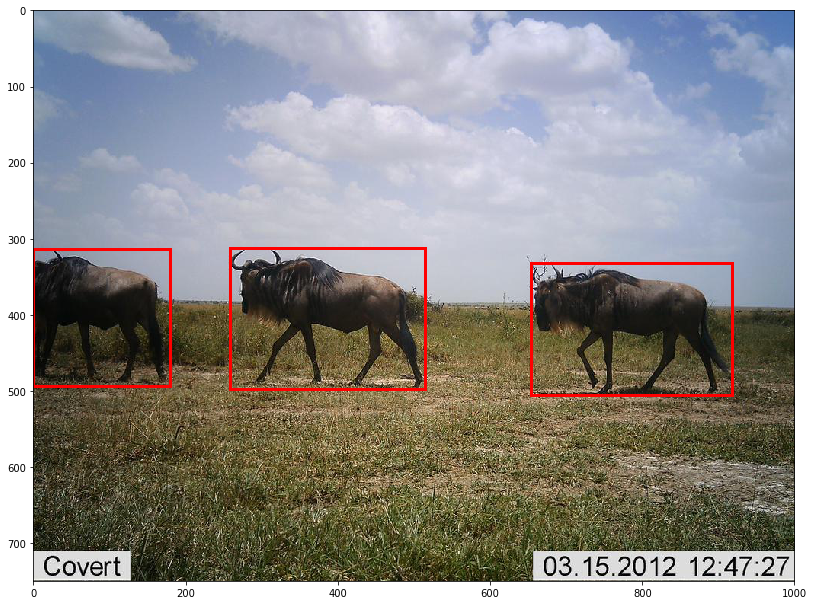

In [16]:
xmins = []
ymins = []
xmaxs = []
ymaxs = []
i = 0
score_threshold = 0.5

img = img0
encoded_jpg_io = io.BytesIO(img)
image = Image.open(encoded_jpg_io)
width, height = image.size

for j in range(0, xmin[0].shape[0]):
    if xmin[0][j][0] == i:
        xmins.append(int(xmin[1][j]*width))
        ymins.append(int(ymin[1][j]*height))
        xmaxs.append(int(xmax[1][j]*width))
        ymaxs.append(int(ymax[1][j]*height))
        


# Create figure and axes
fig,ax = plt.subplots(1)
fig.set_size_inches(18.5, 10.5)
# Display the image
# s = 6
ax.imshow(image)
for s in range(len(xmins)):
    rect = patches.Rectangle((xmins[s],ymins[s]),(xmaxs[s]-xmins[s]), (ymaxs[s] - ymins[s]),linewidth=3,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    
# Plotting the detection
# xmins_d = []
# ymins_d = []
# xmaxs_d = []
# ymaxs_d = []

# for j in range(0, xmin_d[0].shape[0]):
#     if xmin_d[0][j][0] == i and score[1][j]>=score_threshold:
#         xmins_d.append(int(xmin_d[1][j]*width))
#         ymins_d.append(int(ymin_d[1][j]*height))
#         xmaxs_d.append(int(xmax_d[1][j]*width))
#         ymaxs_d.append(int(ymax_d[1][j]*height))


# for s in range(len(xmins_d)):
#     rect = patches.Rectangle((xmins_d[s],ymins_d[s]),(xmaxs_d[s]-xmins_d[s]), (ymaxs_d[s] - ymins_d[s]),linewidth=3,edgecolor='g',facecolor='none')
#     ax.add_patch(rect)

plt.show()

In [18]:
i = 0
for example in tf.python_io.tf_record_iterator('/home/ubuntu/data/tensorflow/my_workspace/training_demo/Predictions/test_schneider_sample.record'):
    result = tf.train.Example.FromString(example)
#     print(result)
    i = i + 1
#     if i == 1:
#         break

print(i)

2
